# Attempts At Improvement

In this document we attempt a few methods at improving the performance of the Logistic Regression model.

### Table of Contents
1. [Dealing With Missing Data](#Dealing-With-Missing-Data)
2. [Tuning the Parameters of the Model](#Tuning-the-Parameters-of-the-Model)
3. [Conclusion](#Conclusion)
4. [References](#References)

We first get our data back into an analysable state.

In [106]:
######## REQUIREMENTS #################
### PLEASE RUN THIS CELL FIRST ########
#######################################

import subprocess
import sys

# List of required packages
required_packages = ['numpy','pandas', 'matplotlib','sklearn']

# Function to check and install packages
def install(package):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

# Check and install required packages
for package in required_packages:
    try:
        __import__(package)
        print(f"'{package}' is already installed.")
    except ImportError:
        print(f"'{package}' not found. Installing...")
        install(package)

print("\nAll required packages are checked/installed.")

'numpy' is already installed.
'pandas' is already installed.
'matplotlib' is already installed.
'sklearn' is already installed.

All required packages are checked/installed.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings('ignore') # we use this to ignore the max_iter warnings we get during the cross-validation testing.

In [4]:
X_train = pd.read_csv("../data/X_train.csv", index_col=0)  # Use the first column as index
y_train = pd.read_csv("../data/y_train.csv", index_col=0)  # Use the first column as index
X_test = pd.read_csv("../data/X_test.csv", index_col=0)    # Use the first column as index
y_test = pd.read_csv("../data/y_test.csv", index_col=0)    # Use the first column as index

In [5]:
X_all = pd.concat({'X_train':X_train, 'X_test':X_test})
objects = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
keys = [0]*len(objects)

for i in range(len(objects)):
    X_all[objects[i]], keys[i] = pd.factorize(X_all[objects[i]])

X_train = X_all.loc['X_train']
X_test = X_all.loc['X_test']

y_all = pd.concat({'y_train':y_train, 'y_test':y_test})
y_all['income'], income_key = pd.factorize(y_all['income'])

y_train = y_all.loc['y_train']
y_test = y_all.loc['y_test']

In [6]:
pipe = make_pipeline(StandardScaler(), linear_model.LogisticRegression())

pipe.fit(X_train, y_train.values.ravel())
y_pred2 = pipe.predict(X_test)

trainscore = pipe.score(X_train, y_train)
testscore = pipe.score(X_test, y_test)

# Dealing With Missing Data

Another thing that may be affecting our model is the missing data. Our data only contains missing entries in the training data and none in the testing data. This is good since we wont be surprised with missing values when testing, but also bad since these missing values could be affecting the efficiency of the model. We will test a couple different methods, namely removing the rows with missing data, or methods of imputing the missing data.

First we check to see where the missing data is:

In [7]:
X_train2 = pd.read_csv("../data/X_train.csv", index_col=0) # Reimport dataset so we have it in it's original state
X_train2.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

There are 3 columns with missing data, namely 'workclass', 'occupation', and 'native-country'. These are all originally object features, and so during our factorising, the NaN values would have been converted to '-1', which we can see below. This could cause problems for our data, especially when we scaled it as the mean and variance will be skewed by these values, and so this motivates us to investigate how fixing this problem will impact our accuracy.

In [8]:
print(X_train['workclass'].unique())

[ 0  1  2  3  4 -1  5  6  7]


One easy way to deal with the data is to simply **remove the rows with missing values**. This can be dangerous for smaller datasets but since for our group the number of rows with missing data is around 10%, this could be a valid way to deal with this.

In [9]:
missingcols = ['workclass','occupation','native-country'] # collect missing columns
X_train_nan = X_train.copy() # We no longer want to alter the original dataframe so we make a copy for our tests

# convert the missing values from -1 back to nan, so that we can then use the .dropna method
for col in missingcols:
    X_train_nan.loc[X_train[col] == -1,col] = np.nan

X_y_All = pd.concat({'X_train':X_train_nan,'y_train':y_train},axis=1)
X_y_All = X_y_All.dropna()

X_train2 = X_y_All.loc[:,'X_train']
y_train2 = X_y_All.loc[:,'y_train']

In [10]:
pipe_rem = make_pipeline(StandardScaler(), linear_model.LogisticRegression())
pipe_rem.fit(X_train2, y_train2.values.ravel())

y_pred_rem = pipe_rem.predict(X_test)

trainscore_rem = pipe_rem.score(X_train, y_train) # Using the model trained on the removed rows back on the dataset with missing values
testscore_rem = pipe_rem.score(X_test, y_test)
print(f'The training score with removed rows: {trainscore_rem}')
print(f'The training score without removed rows: {trainscore}\n')
print(f'The test score with removed rows: {testscore_rem}')
print(f'The test score without removed rows: {testscore}')

The training score with removed rows: 0.8268466837632624
The training score without removed rows: 0.8258912857645698

The test score with removed rows: 0.8198059108954565
The test score without removed rows: 0.8201367445963829


We see that removing the rows has infact increased our training score but decreased the testing score, we can't conclude much from this and will continue to investigate imputing before comparing all of the methods at the end.

We will now investigate a few different methods of **imputing**, namely mean, mode, and median imputation. Imputing is the act of filling in missing data by predicting what the data could be based on the other data. Mean, mode, and median imputing are 3 very simple methods of doing this, and whilst there are more complex methods available, such as Multiple Imputation, but that is too complex for this simple digression. We will investigate now:

In [11]:
X_train_mean = X_train_nan.copy()
X_train_mode = X_train_nan.copy()
X_train_medi = X_train_nan.copy()

for col in missingcols:
    col_mean = X_train_nan[col].mean()
    col_mode = (X_train_nan[col].mode())[0]
    col_medi = X_train_nan[col].median()
    X_train_mean.fillna({col: col_mean}, inplace=True)
    X_train_mode.fillna({col: col_mode}, inplace=True)
    X_train_medi.fillna({col: col_medi}, inplace=True)

pipe_mean = make_pipeline(StandardScaler(), linear_model.LogisticRegression())
pipe_mode = make_pipeline(StandardScaler(), linear_model.LogisticRegression())
pipe_medi = make_pipeline(StandardScaler(), linear_model.LogisticRegression())

pipe_mean.fit(X_train, y_train.values.ravel())
pipe_mode.fit(X_train, y_train.values.ravel())
pipe_medi.fit(X_train, y_train.values.ravel())

y_pred_mean = pipe_mean.predict(X_test)
y_pred_mode = pipe_mode.predict(X_test)
y_pred_medi = pipe_medi.predict(X_test)

trainscore_mean = pipe_mean.score(X_train_mean,y_train)
trainscore_mode = pipe_mode.score(X_train_mode,y_train)
trainscore_medi = pipe_medi.score(X_train_medi,y_train)

In [12]:
print(f'Normal Model Score          = {trainscore}')
print(f'Removed Rows Model Score    = {trainscore_rem}')
print(f'Mean Imputing Model Score   = {trainscore_mean}')
print(f'Mode Imputing Model Score   = {trainscore_mode}')
print(f'Median Imputing Model Score = {trainscore_medi}')

Normal Model Score          = 0.8258912857645698
Removed Rows Model Score    = 0.8268466837632624
Mean Imputing Model Score   = 0.8254638708704178
Mode Imputing Model Score   = 0.8254638708704178
Median Imputing Model Score = 0.8255141549756122


We see that the training scores for all of these imputing methods are worse than both the normal model, and the model where we removed the rows. This suggests to us that the missing data did not play a strong part in our model, which is reinforced by the fact that the mean and mode imputing end up giving us the same score. In our normal model, in a sense we were encoding the missing data as it's own category, this is because the method we used to encode the rows encodes `NaN` data as `-1`, and so it is treated as it's own category. From our EDA in document `02.1`, we saw that the majority of the missing data came from individuals earning less than 50k a year, and so treating this as it's own category may infact assist our model in identifying the cases for less than 50k.

# Tuning the Parameters of the Model

The LogisticRegression function in sklearn has a parameter known simply as `C`, set to `C = 1` by default. This parameter represents the inverse of the regularisation strength, where smaller values represent stronger regularisation. In our case, the training and testing scores are fairly similar and so we don't need to worry about potential overfitting, but we may have some underfitting. A good way to tune parameters in models is through a process known as cross-validation, which leaves out sections of the training data to be used to test the models and compare the values of the parameters. Scikit-Learn has a built in model to do this, known as `LogisticRegressionCV`, which does all of the work for you, but we will instead implement a method known as `GridSearchCV` so that we can understand what is going on better. This allows us to try a combination of values of the parameters. We will mainly be trying to tune `C`, but will also try and tune `max_iter`. This section follows guidance from [\[1\]](#References).

First we get the scaled data back:

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),index=X_train.index,columns=X_train.columns)

scaler = StandardScaler()
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test),index=X_test.index,columns=X_test.columns)

lrcv = linear_model.LogisticRegression()
lrcv.fit(X_train_scaled,y_train.values.ravel())

LogisticRegression()

Now we create a list of parameters that we want to tune, and the values we want them to take. We do this using a dictionary for convenience. We then apply the gridsearch to our model, and show some of the results in a table. In total there will be `len(parameters['C']) * len(parameters['max_iter'])` cases considered. We will do an exhaustive search for the best `C` values, by checking 500 evenly spaced values between 0 and 10, and using $10$ and $100$ for `max_iter` values, giving a total of 1000 estimations, which takes a while to compute. We then plot the mean score for each set of parameters to get a better look at the values.

In [103]:
parameters = {'C': np.linspace(0.02,10,500), # creates a 1D array containing a list of all numbers 0.02, 0.04, 0.06, ..., 9.98, 10.00
              'max_iter': [10,100]}

grid = GridSearchCV(estimator = lrcv, param_grid = parameters, cv = 5, refit = True)
grid.fit(X_train_scaled, y_train.values.ravel())
# We ignore that output for now as we will come back to that after the plot.

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([ 0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,
        0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,
        0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,  0.54,
        0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,  0.72,
        0.74,  0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ,
        0.92,  0.94,  0.96,  0.98,  1.  ,  1.02,  1.04,  1.06,  1.08,
        1.1 ,  1.12,  1.14,  1.16,...
        8.48,  8.5 ,  8.52,  8.54,  8.56,  8.58,  8.6 ,  8.62,  8.64,
        8.66,  8.68,  8.7 ,  8.72,  8.74,  8.76,  8.78,  8.8 ,  8.82,
        8.84,  8.86,  8.88,  8.9 ,  8.92,  8.94,  8.96,  8.98,  9.  ,
        9.02,  9.04,  9.06,  9.08,  9.1 ,  9.12,  9.14,  9.16,  9.18,
        9.2 ,  9.22,  9.24,  9.26,  9.28,  9.3 ,  9.32,  9.34,  9.36,
        9.38,  9.4 ,  9.42,  9.44,  9.46,  9.48,  9.5 ,  9.52,  9.54,
        9.56,  9.58,  9.6 ,  9.62,  9.64,  9.66,  9.68,  9.7 ,  9.72,
        9.74,  9.76,  9.78,  9.8 ,  9.82,  9.84,  9.86,  9.88,  9.9 ,
        9.92,  9.94,  9.96,  9.98, 10.  ]),
                         'max_iter': [10, 100]})

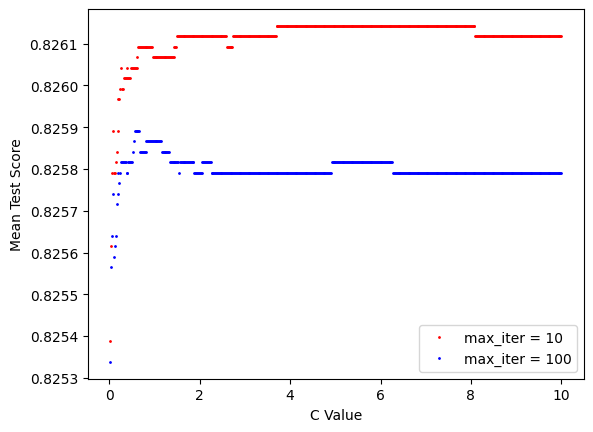

In [104]:
mean_test_scores = pd.DataFrame(grid2.cv_results_).loc[:,'mean_test_score']
params = pd.DataFrame(grid2.cv_results_).loc[:,'params']

C_list = [list(params)[i]['C'] for i in range(len(list(params)))]
C_list_10 = [C_list[2*i] for i in range(len(list(params))//2)]
C_list_100 = [C_list[(2*i) + 1] for i in range(len(list(params))//2)]

mean_test_scores_10 = [mean_test_scores[2*i] for i in range(len(list(params))//2)]
mean_test_scores_100 = [mean_test_scores[(2*i) + 1] for i in range(len(list(params))//2)]

plt.plot(C_list_10,mean_test_scores_10,'ro',markersize=1)
plt.plot(C_list_100,mean_test_scores_100,'bo',markersize=1)
plt.xlabel('C Value')
plt.ylabel('Mean Test Score')
plt.legend(['max_iter = 10','max_iter = 100'])
plt.show()

This plot shows us that interestingly enough, some of the scores are actually higher than our initial training score, especially those using `max_iter = 10` which are higher across the board.

We now extract the best model and check the parameters.

In [105]:
best_lrcv = grid.best_estimator_
print(f'The model with the best performance had parameters: {grid.best_params_},')
print(f'and score: {grid.best_score_},')
print(f'compared to our initial training score: {trainscore}')

The model with the best performance had parameters: {'C': 3.7, 'max_iter': 10},
and score: 0.8261426363121576,
compared to our initial training score: 0.8258912857645698


We see that `C = 3.7`, `max_iter = 10` give us the best score, which is in fact higher than our initial testing score. This seems promising so we check how this model scores on the testing data.

In [102]:
testscore_lrcv = best_lrcv.score(X_test_scaled,y_test.values.ravel())

print(testscore)
print(testscore_lrcv,'\n')

0.8201367445963829
0.8198059108954565 



Unfortunately, we see that the testing score is lower than before. This suggests that the default parameters were already quite optimal. A limitation of Cross-Validation is that the data is trained on a smaller training set. In our case since we are using 5-fold Cross-Validation, the training data is split into an 80%-20%, trained on the 80% and then validated on the 20%, meaning that the model only has 80% as much data as before, which is likely what resulted in the lower performance. Another limitation of this method is that it can lead to more overfitting due to this lesser data and thus less opportunity to smooth out the inherent noise in the data. If we check the documentation [\[2\]](#References) for `GridSearchCV` we see that it naturally uses the `StratifiedKFold` method for splitting the data, which retains the distribution of the data in the folds. This is helpful for our data since we have imbalanced data in many of the features, but unfortunately this does not seem to have been enough to improve the model.

# Summary

In this document we have unfortunately seen that improving this model is a difficult task with multiple different methods and attempts failing to achieve any real improvements. This suggests that rather than there being a problem with our application of the model, there is infact a problem with the dataset that makes it incompatible with this model. This will be further explored in the next document, `04.3-Discussion.ipynb`.

# References

[1] Medium: Understanding Grid Search/Randomized CV’s (refit=True) - https://orvindemsy.medium.com/understanding-grid-search-randomized-cvs-refit-true-120d783a5e94

[2] Scikit-Learn Documentation: GridSearchCV - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html